In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

load data set

In [33]:
X_train=np.loadtxt('C:/Users/Personal/Desktop/my_cat_AI/Data/input.csv',delimiter=',')
Y_train=np.loadtxt('C:/Users/Personal/Desktop/my_cat_AI/Data/labels.csv',delimiter=',')

X_test=np.loadtxt('C:/Users/Personal/Desktop/my_cat_AI/Data/input_test.csv',delimiter=',')
Y_test=np.loadtxt('C:/Users/Personal/Desktop/my_cat_AI/Data/labels_test.csv',delimiter=',')

In [34]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2000, 30000)
(2000,)
(400, 30000)
(400,)


In [35]:
X_train=X_train.reshape(len(X_train),100,100,3) #reshape to 100x100 pixels x3 rgb colors
Y_train=Y_train.reshape(len(Y_train),1)
X_test=X_test.reshape(len(X_test),100,100,3)
Y_test=Y_test.reshape(len(Y_test),1)


X_train=X_train/255.0
X_test=X_test/255.0

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2000, 100, 100, 3)
(2000, 1)
(400, 100, 100, 3)
(400, 1)


<function matplotlib.pyplot.show(close=None, block=None)>

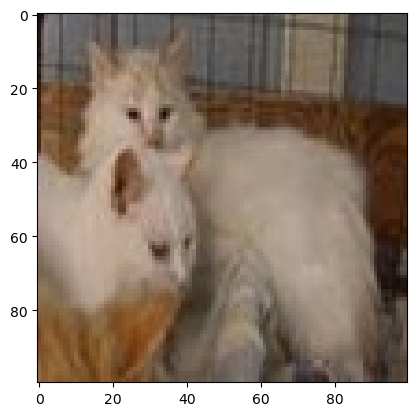

In [36]:
idx=random.randint(0,len(X_train))
plt.imshow(X_train[idx,:])
plt.show

In [37]:
# model=Sequential()

# model.add(Conv2D(32,(3,3),activation='relu',input_shape=(100,100,3)))
# model.add(MaxPooling2D((2,2)))

# model.add(Conv2D(32,(3,3),activation='relu',input_shape=(100,100,3)))
# model.add(MaxPooling2D((2,2)))

# model.add(Flatten())
# model.add(Dense(64,activation='relu'))
# model.add(Dense(1,activation='sigmoid'))

#model

In [38]:
model=Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(100,100,3)),
    MaxPooling2D((2,2)),#stride =2

    Conv2D(32,(3,3),activation='relu'),#input shape only for first layer
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(64,activation='relu'),
    Dense(1,activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


or


loss, backprop

In [48]:
def calculate_flops(model):
    flops = 0
    for layer in model.layers:
        if isinstance(layer, Conv2D):
            _, H, W, C_in = layer.input_shape
            C_out, K_h, K_w, _ = layer.kernel.shape
            flops_per_instance = 2 * K_h * K_w * C_in * C_out
            flops_per_layer = flops_per_instance * H * W
            flops += flops_per_layer
        elif isinstance(layer, Dense):
            N_in = layer.input_shape[-1]
            N_out = layer.output_shape[-1]
            flops_per_layer = 2 * N_in * N_out
            flops += flops_per_layer
        # MaxPooling2D and other layers can be added here if needed

    return flops

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2)),  # stride=2

    Conv2D(32, (3, 3), activation='relu'),  # input shape only for the first layer
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

flops = calculate_flops(model)
print(f'Total FLOPs: {flops}')


Total FLOPs: 48042144


In [49]:
#my model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2)),  # stride=2

    Conv2D(32, (3, 3), activation='relu'),  # input shape only for the first layer
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set up the profiler
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Convert Keras model to a ConcreteFunction
model_func = tf.function(lambda x: model(x))
model_func = model_func.get_concrete_function(tf.TensorSpec([1, 100, 100, 3], tf.float32))

# Convert ConcreteFunction to a frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(model_func)

# Calculate FLOPs
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io

def get_flops(frozen_func):
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()    
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph, run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops

flops = get_flops(frozen_func)
print(f'Total FLOPs: {flops}')

Total FLOPs: 60232033


In [50]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_16 (Flatten)        (None, 16928)             0         
                                                                 
 dense_32 (Dense)            (None, 64)              

In [42]:
model.fit(X_train,Y_train,epochs=5,batch_size=64)

Epoch 1/5
32/32 [==============================] - 9s 213ms/step - loss: 0.7124 - accuracy: 0.4920
Epoch 2/5
32/32 [==============================] - 7s 212ms/step - loss: 0.6590 - accuracy: 0.6185
Epoch 3/5
32/32 [==============================] - 10s 311ms/step - loss: 0.5701 - accuracy: 0.7040
Epoch 4/5
32/32 [==============================] - 8s 250ms/step - loss: 0.5005 - accuracy: 0.7610
Epoch 5/5
32/32 [==============================] - 7s 224ms/step - loss: 0.4196 - accuracy: 0.8140


In [43]:
model.evaluate(X_test,Y_test)

13/13 [==============================] - 1s 42ms/step - loss: 0.6267 - accuracy: 0.6700


[0.6266560554504395, 0.6700000166893005]

making the predictions

<function matplotlib.pyplot.show(close=None, block=None)>

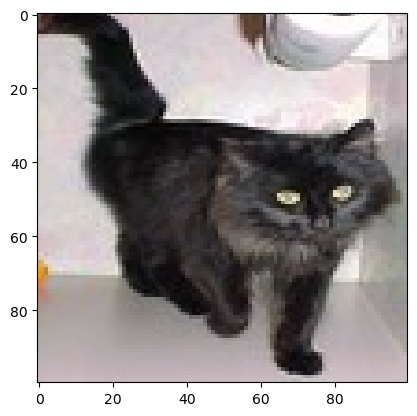

In [44]:
idx2=random.randint(0,len(X_test))
plt.imshow(X_test[idx2,:])
plt.show

In [45]:
y_pred=model.predict(X_test[idx2,:].reshape((1,100,100,3)))#has to be inshape!
print(y_pred)

if y_pred < 0.5:
    print("Dog")
else:
    print("Cat")

1/1 [==============================] - 0s 124ms/step
[[0.55998045]]
Cat


In [53]:
#ali's model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Define the model
inputs = Input(shape=160)
x = Dense(320, activation='relu')(inputs)
x = Dense(320, activation='relu')(x)

outputs = []  # List to store output layers
for i in range(100):
    output = Dense(1, activation="sigmoid")(x)
    outputs.append(output)

model = Model(inputs=inputs, outputs=outputs)

# Convert Keras model to a ConcreteFunction
model_func = tf.function(lambda x: model(x))
model_func = model_func.get_concrete_function(tf.TensorSpec([1, 160], tf.float32))

# Convert ConcreteFunction to a frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(model_func)

# Calculate FLOPs
def get_flops(frozen_func):
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()    
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph, run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops

flops = get_flops(frozen_func)
print(f'Total FLOPs: {flops}')

model.summary()

Total FLOPs: 371940
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 160)]                0         []                            
                                                                                                  
 dense_136 (Dense)           (None, 320)                  51520     ['input_2[0][0]']             
                                                                                                  
 dense_137 (Dense)           (None, 320)                  102720    ['dense_136[0][0]']           
                                                                                                  
 dense_138 (Dense)           (None, 1)                    321       ['dense_137[0][0]']           
                                                                        

In [3]:
#GRU
from keras.layers import Input, GRU, Dense
from keras.models import Model
from keras.optimizers import Adam

# Configuration parameters
input_dim = 1  # Assuming single feature input (adjust as necessary)
output_dim = 1  # Assuming single output (adjust as necessary)
gru_units = 502  # Number of GRU units
learning_rate = 1e-3
batch_size = 3200
epochs = 100

def build_gru_model(input_dim, output_dim, gru_units):
    inputs = Input(shape=(None, input_dim))
    gru_out = GRU(gru_units, return_sequences=False)(inputs)
    outputs = Dense(output_dim)(gru_out)
    model = Model(inputs, outputs)
    return model

model = build_gru_model(input_dim, output_dim, gru_units)

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 502)            │       760,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           503 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 761,033 (2.90 MB)

 Trainable params: 761,033 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
#GRU2
input_dim = 1  
model = Sequential()
model.add(GRU(units=50, input_shape=(None, input_dim), return_sequences=True))
model.add(GRU(units=50))
model.add(Dense(units=output_dim))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Summary of the model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, None, 50)       │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
def generate_prototxt():
    prototxt = """
name: "example_network"
layer {
  name: "input"
  type: "Input"
  top: "input"
  input_param { shape: { dim: 1 dim: 160 } }
}

layer {
  name: "dense1"
  type: "InnerProduct"
  bottom: "input"
  top: "dense1"
  inner_product_param {
    num_output: 320
  }
}

layer {
  name: "relu1"
  type: "ReLU"
  bottom: "dense1"
  top: "dense1"
}

layer {
  name: "dense2"
  type: "InnerProduct"
  bottom: "dense1"
  top: "dense2"
  inner_product_param {
    num_output: 320
  }
}

layer {
  name: "relu2"
  type: "ReLU"
  bottom: "dense2"
  top: "dense2"
}
"""

    for i in range(100):
        prototxt += f"""
layer {{
  name: "output{i+1}"
  type: "InnerProduct"
  bottom: "dense2"
  top: "output{i+1}"
  inner_product_param {{
    num_output: 1
  }}
}}

layer {{
  name: "Sigmoid{i+1}"
  type: "Sigmoid"
  bottom: "output{i+1}"
  top: "output{i+1}"
}}
"""
    
    with open("network.prototxt", "w") as f:
        f.write(prototxt)

# Run the function to generate the file
generate_prototxt()
